# P3 - Wrangle OpenStreetMap Data
***by Bruno de Assis Pereira***

---
In this project, I am going to present a process of **data wrangling** over a dataset extracted from the ***OpenStreetMap***. In this case, I have selected the map from **Curitiba**, one of Brazil's capitals, and I am going to apply different techniquics for *analysing, cleaning and standardizing* this data so I can finally load into a **MongoDB** database and develop some queries over the final dataset.

Let's start!

### Analyzing Tags within the Dataset
To start getting to know how this dataset is structured is a good idea to take a look at the *tags* that we are going to be dealing with:
```python
{'bounds': 1,
 'member': 6957,
 'nd': 371292,
 'node': 282662,
 'osm': 1,
 'relation': 1191,
 'tag': 159749,
 'way': 51402}
```
For the purposes of this project, from the above set, we are going to be dealing with only ***nodes, ways and tags***.
### How many users had interacted with this dataset?
To understand or at least have some idea of how this dataset can have different kinds of input, we could take a look at how many users had interacted with these data. From this analysis, we can see how many different points of view were applied over these data.
```python
users = set()
for _, element in ET.iterparse(OSMFILE):
    if element.attrib.get('user') is not None:
        users.add(element.attrib['user'])

print "Users set size: %i\n" % len(users)
pprint.pprint(users)
```
With this script we can see all of the different users and know that **556 users** already interacted somehow with this data.
### Analyzing keys for selection
Ok, so we know that we are probably going to see lots of different inputs, but this dataset has a lot of interesting information that we can dig into. We need to select what exactly we are going to be auditing here. For this reason, I took a look on what were our possibilities by verifying the keys that were available for each tag.
From the list that I have found, I selected some itens to interact with:
- addr:city
- addr:street
- addr:state
- addr:postcode
- recycling
- opening_hours

Besides that, I will also add information to each of my elements related to **creation** of the registry and **position** in latitude and longitude of the specified element. Those elements will then be ready for **loading** into the database.
### Cleaning and Standardizing the Dataset
The dataset that I am dealing with presents lots of data without a defined standard. This can turn into a bigger problem once we start to extract statistics from these data since it can be misleading.
**Cleaning and Standardizing** this data will provide a more reliable information in the end.
**And how can we do this?** Using *regular expressions* and functions to update the name of the fields and providing some standards to the values of those fields. One of the functions that I developed was the one below that was responsible for mapping the values to a defined standard.
```python
#function to update fields according to the selected type (t - 'c': Cities | 's': Street | 'w': Weekday)
def update_name(name, mapping, t):
    if t == 'c':
        for key in mapping.keys():
            if name == key.decode('utf-8'):
                name = mapping[key]
    elif t == 's':
        for key in mapping.keys():
            if re.search(r'^'+key+' ',name):
                name = name.replace(key, mapping[key])
                name = name.replace('.','')
    elif t == 'w':
        for key in mapping.keys():
            dkey = key.decode('utf-8')
            weekday_re = re.compile(ur' '+dkey+' |'+dkey+' |'+dkey+'-|-'+dkey+' |'+dkey+'$|'+dkey+':|'+dkey+',', re.UNICODE)
            if weekday_re.search(name):
                name = name.replace(key.decode('utf-8'), mapping[key])
                
    return name
```
One of the classes that I selected, **opening_hours**, was the one that gave me more headaches to put it into a standard so I could perform queries over this data later on. These are some of the formats that I have found for the values that this class could assume:
```python
'08:00-18:00'
'08:00 - 18:00'
'08:00 as 18:00 hs'
'24/7'
'08:00-12:00;13:00-18:00'
'Mo-Fr'
'mo-fr 08:00-18:00; sa 09:00-13:00'
'Mo-We 17:00-00:00; Th-Fr 17:00-01:00; Sa 12:00-22:00'
...
```
I have developed a bunch of functions that could handle almost all cases and I also ignored some specific ones that were too messy to try to correct then somehow.

### Preparing data for Loading

Once we created functions to clean the data, now we can start to structure the data so it can be stored in a database.
For this part I developed a function called *shape_element* and used it.
After that, I made some queries over the database.

```python
result=db.elements.aggregate([
    {"$match" : {"$or" : [{"type" : "node"},{"type" : "way"}]}},
    {"$group" : {"_id" : "$type",
                 "count" : {"$sum" : 1}}},
    {"$sort" : {"count" : -1}}
])

{u'_id': u'node', u'count': 282662}
{u'_id': u'way', u'count': 51397}
```

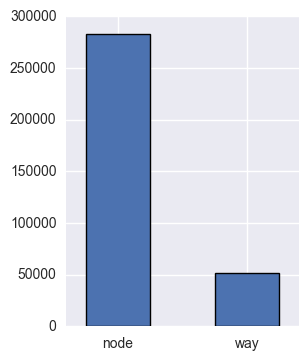

In [2]:
from IPython.display import Image
Image("graph.png")

```python
result=db.elements.find({"opening_hours" : {"$exists" : 1}
                         ,"opening_hours.Sun" : {"$ne" : []}
                         ,"opening_hours.Mon" : {"$ne" : []}
                         ,"opening_hours.Tue" : {"$ne" : []}
                         ,"opening_hours.Wed" : {"$ne" : []}
                         ,"opening_hours.Thu" : {"$ne" : []}
                         ,"opening_hours.Fri" : {"$ne" : []}
                         ,"opening_hours.Sat" : {"$ne" : []}
                        }
                        ,{"name" : 1
                         ,"amenity" : 1
                         ,"shop" : 1
                         ,"_id" : 0}
                       ).limit(10)

109 Establishments

{u'name': u'Mercadorama', u'shop': u'supermarket'}
{u'amenity': u'fuel', u'name': u'Posto O Cupim 2', u'shop': u'kiosk'}
{u'amenity': u'fuel', u'shop': u'kiosk'}
{u'amenity': u'pharmacy', u'name': u'FarmaTotal'}
{u'amenity': u'atm'}
{u'name': u'Engenho do P\xe3o', u'shop': u'bakery'}
{u'name': u'Sempre Mais', u'shop': u'supermarket'}
{u'amenity': u'post_office', u'name': u'ACF Rui Barbosa'}
{u'name': u'Cicles Carneiro', u'shop': u'sports'}
{u'amenity': u'pharmacy', u'name': u'Farmacia FarmaTotal'}
```

Despite being very simple queries, they showed me very interisting data. For instance, if we try to get how many establishments are open during the weekend to each city, we would have the following answer:

```python
result=db.elements.aggregate([
    {"$match" : {"opening_hours" : {"$exists" : 1}
                ,"opening_hours.Sat" : {"$ne" : []}
                ,"opening_hours.Sun" : {"$ne" : []}}},
    {"$group" : {"_id" : "$address.city",
                 "count" : {"$sum" : 1}}},
    {"$sort" : {"count" : -1}}
])

{u'_id': None, u'count': 59}
{u'_id': u'Curitiba', u'count': 44}
{u'_id': u'S\xe3o Jos\xe9 dos Pinhais', u'count': 5}
{u'_id': u'Pinhais', u'count': 1}
```

The first thing to take into account is that most of the establishments have no city associated to them. Besides that, the numbers that we have to the third and forth cities are too low, so it is probably not real numbers. And the most important part:

```python
15 Cities

u'Curitiba'
u'S\xe3o Jos\xe9 dos Pinhais'
u'Arauc\xe1ria'
u'Jardim Am\xe9lia - Pinhais'
u'Fanny'
u'Campo Largo'
u'Tarum\xe3'
u'Almirante Tamandar\xe9'
u'Pinhais'
u'Batel'
u'Alto da Rua XV'
u'Rebou\xe7as'
u'Cajuru'
u'Colombo'
u'Rio Verde'
```

We have **15 cities** in this dataset and **only 4** appeared in the previous query for the establishments openned during the weekend. This kind of result show us that we have a lot of missing data and for this reason we cannot develop reliable statistics over this dataset.
To this kind of dataset present more reliable data, we would need more interaction of users to fill those gaps.

### How To Improve?

One thing that would help a lot for future uses of this data would be to **define some restrictions to the users** when they are putting new registries in the dataset. For instance, if the users had to follow some standards to put new data on the dataset, things would become a lot easier to maintain and to perform queries over it. One of the struggles that I have had over this dataset was to deal with the *opening_hours* element, and that is only because users could store this information in any kind of format. However, define this kind of standards will not be easy since we can have lots of **correct** ways of defining the values for the different registries. For instance, if we take *dates*, some countries have a way of presenting a date while others do it differently.
Besides that, to achieve completeness, we could get data from other sources such as Google Maps.

---
### References
---
- **OSM XML**: https://wiki.openstreetmap.org/wiki/OSM_XML
- **Python - Regular Expression Operation Documentation:** https://docs.python.org/2/library/re.html
- **MongoDB - Query Documents:** https://docs.mongodb.com/manual/tutorial/query-documents/